# Chapter5 : Deep learning for computer vision

## 5.3 Using a pretained convnet

A common and highly effective approach to deep learning on small image datasets is to use a pretrained network. A *pretrained network* is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task.

If the original dataset is large enough and general enough, then the spacial hierarchy of features learned by the pretrained network can effectively act as a generic model, and hence its features can prove useful for even new problems that may involve completely different classes than those of the original task.

Such portability of learned features across different problems is a key advantage of deep learning compared to many older, shallow-learning approaches, and it makes deep learning very effective for small-data problems.

There are two ways to use a pretrained network: ***feature extraction*** and ***fine-tuning***.

### 5.3.1 Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

Convnets used for image classification comprise two parts: they start with a series of pooling and convolution layers, and they end with a densely connected classifier. The first part is called the ***convolutional base*** of the model.

In the case of convnets, feature extraction consists of taking the convolutional base of a previously trained network, running the new data through it, and training a new classifier on top of the output.

**But why only reuse the convolutional base and not the densely connected classifier as well?**

The reason is that the representations learned by the convolutional base are likely to be more generic and therefore more reuseable. The representations learned by the classifier will necessarily be specific to the set of classes on which the model was trained. Additionally, representations found in densely connected layers no longe contain any information about *where* objects are located in the input image.

Note that the level of generality of the representations extracted by specific convolution layers depends on the depth of the layer in the model.
  + Layers that come earlier in the model extract local, highly generic feature maps (eg. visual edges, colors, textures)
  + Layers that are higher up extract more-abstract concepts (eg. cat ear, dog eye)

The following is the list of image-classification models (all pretrained on the ImageNet dataset) that are available as part of **keras.applications**:
  + Xception
  + Inception V3
  + ResNet50
  + VGG16
  + VGG19
  + MobileNet

#### Instantiating the VGG16 convolutional base

In [2]:
from keras.applications import VGG16

Using TensorFlow backend.


In [0]:
conv_base = VGG16(weights = 'imagenet',
                  include_top = False,   # refers to including the densely connected classifier 
                                          # on top of the network
                  input_shape = (150,150,3))

In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

The final feature map has shape (4,4,512). At this point, there are two ways you could proceed:
  + Running the convolutional base over your dataset, recording its output to a Numpy array on disk, and then using this data as input to a standalone, densely connected classifier.
    - fast and cheap to run
    - data augmentation is not allowed
  + Extending the model you have by adding Dense layers on top, and running the whole thing end to end on the input data.
    - data augmentation is allowed
    - far more expensive

#### FAST FEATURE EXTRACTION WITHOUT DATA AUGMENTATION

#### Extracting features using the pretrained convolutional base

In [0]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
base_dir = '/content/gdrive/My Drive/github/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [0]:
datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20

In [0]:
def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count, 4, 4, 512))
    labels = np.zeros(shape = (sample_count))
    generator = datagen.flow_from_directory(
         directory,
         target_size = (150,150),
         batch_size = batch_size,
         class_mode = 'binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size : (i+1)*batch_size] = features_batch
        labels[i*batch_size : (i+1)*batch_size] = labels_batch
        i += 1
        if i*batch_size >= sample_count:
            break   # generators yield data indefinitely in a loop
    return features, labels

In [10]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

#### Defining and training the densely connected classifier

In [0]:
from keras import models
from keras import layers, optimizers

In [0]:
model = models.Sequential()

model.add(layers.Dense(256, activation = 'relu', input_dim = 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = optimizers.RMSprop(lr = 2e-5),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

In [14]:
history = model.fit(train_features, train_labels,
                    epochs = 20,
                    batch_size = 20,
                    validation_data = (validation_features, validation_labels),
                    verbose = 2)

Train on 2000 samples, validate on 1000 samples
Epoch 1/20
 - 1s - loss: 0.5503 - acc: 0.7250 - val_loss: 0.4345 - val_acc: 0.8280
Epoch 2/20
 - 0s - loss: 0.4144 - acc: 0.8120 - val_loss: 0.3599 - val_acc: 0.8600
Epoch 3/20
 - 1s - loss: 0.3504 - acc: 0.8500 - val_loss: 0.3230 - val_acc: 0.8780
Epoch 4/20
 - 1s - loss: 0.3101 - acc: 0.8770 - val_loss: 0.3088 - val_acc: 0.8740
Epoch 5/20
 - 0s - loss: 0.2788 - acc: 0.8845 - val_loss: 0.2867 - val_acc: 0.8880
Epoch 6/20
 - 1s - loss: 0.2600 - acc: 0.8970 - val_loss: 0.2808 - val_acc: 0.8830
Epoch 7/20
 - 0s - loss: 0.2460 - acc: 0.9090 - val_loss: 0.2693 - val_acc: 0.8970
Epoch 8/20
 - 1s - loss: 0.2350 - acc: 0.9145 - val_loss: 0.2634 - val_acc: 0.8990
Epoch 9/20
 - 0s - loss: 0.2180 - acc: 0.9190 - val_loss: 0.2676 - val_acc: 0.8910
Epoch 10/20
 - 1s - loss: 0.2067 - acc: 0.9145 - val_loss: 0.2622 - val_acc: 0.8950
Epoch 11/20
 - 0s - loss: 0.1868 - acc: 0.9355 - val_loss: 0.2608 - val_acc: 0.8930
Epoch 12/20
 - 1s - loss: 0.1840 - ac

#### Plotting the results

In [0]:
import matplotlib.pyplot as plt

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

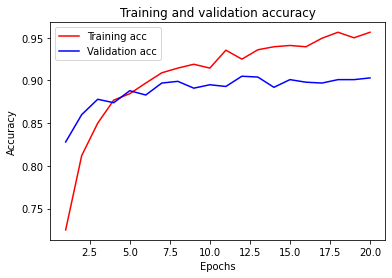

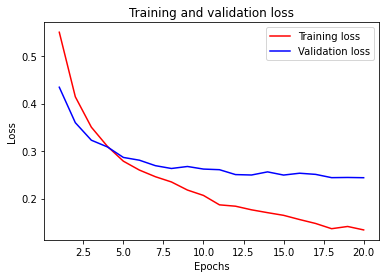

In [17]:
plt.plot(epochs, acc, 'r', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

> You reach a validation accuracy of about 90%--much better than the small model trained from scratch in the previous section.

> However, plots indicate overfitting almost from the start, despite using dropout. This is because this technique doesn't use data augmentation, which is essential for preventing overfitting with small image datasets.

#### FEATURE EXTRACTION WITH DATA AUGMENTATION

#### Adding a densely connected classifier on top of the convolutional base

In [0]:
from keras import models, layers

In [0]:
model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


Before you compile and train the model, it's very important to freeze the convolutional base. *Freezing* a layer or set of layers means preventing their weights from being updated during training. If you don't do this, then the representations that were previously learned by the convolutional base will be modified during training, effectively destroying the representations previously learned.

In [21]:
print('This is the number of trainable weights ',
      'before freezing the conv base:',
      len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights ',
      'after freezing the conv base:',
      len(model.trainable_weights))

This is the number of trainable weights  before freezing the conv base: 30
This is the number of trainable weights  after freezing the conv base: 4


Note that in order for these changes to take effect, you must first compile the model. If you ever modify weight trainability after compilation, you should then recompile the model, or these changes will be ignored.

#### Training the model end to end with a frozen convolutional base

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
from keras import optimizers

In [23]:
train_datagen = ImageDataGenerator(
     preprocessing_function = preprocess_input,
     rotation_range = 40,
     width_shift_range = 0.20,
     height_shift_range = 0.20,
     shear_range = 0.20,
     zoom_range = 0.20,
     horizontal_flip = True,
     fill_mode = 'nearest')

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

train_generator = train_datagen.flow_from_directory(
     train_dir,
     target_size = (150,150),
     batch_size = 20,
     class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(
     validation_dir,
     target_size = (150,150),
     batch_size = 20,
     class_mode = 'binary')

model.compile(optimizer = optimizers.RMSprop(lr = 2e-5),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [24]:
history = model.fit_generator(
     train_generator,
     steps_per_epoch = 100,
     epochs = 20,
     validation_data = validation_generator,
     validation_steps = 50,
     verbose = 2)

Epoch 1/20
 - 23s - loss: 2.3001 - acc: 0.7695 - val_loss: 1.6487 - val_acc: 0.9090
Epoch 2/20
 - 21s - loss: 1.1073 - acc: 0.8645 - val_loss: 4.3275e-06 - val_acc: 0.9300
Epoch 3/20
 - 21s - loss: 0.8019 - acc: 0.9030 - val_loss: 0.1404 - val_acc: 0.9380
Epoch 4/20
 - 21s - loss: 0.6003 - acc: 0.9170 - val_loss: 4.9801e-04 - val_acc: 0.9500
Epoch 5/20
 - 21s - loss: 0.6213 - acc: 0.9180 - val_loss: 0.6497 - val_acc: 0.9490
Epoch 6/20
 - 22s - loss: 0.4867 - acc: 0.9285 - val_loss: 0.2988 - val_acc: 0.9500
Epoch 7/20
 - 22s - loss: 0.5981 - acc: 0.9330 - val_loss: 0.0700 - val_acc: 0.9520
Epoch 8/20
 - 22s - loss: 0.4876 - acc: 0.9255 - val_loss: 2.8825e-09 - val_acc: 0.9550
Epoch 9/20
 - 22s - loss: 0.4709 - acc: 0.9385 - val_loss: 1.0833 - val_acc: 0.9600
Epoch 10/20
 - 22s - loss: 0.4224 - acc: 0.9335 - val_loss: 1.6337e-05 - val_acc: 0.9560
Epoch 11/20
 - 22s - loss: 0.4647 - acc: 0.9365 - val_loss: 1.5461e-10 - val_acc: 0.9560
Epoch 12/20
 - 22s - loss: 0.3453 - acc: 0.9445 - val_

In [0]:
model.save('cats_and_dogs_small_3.h5')

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

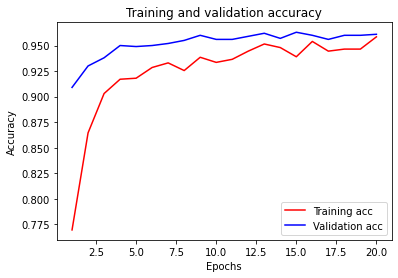

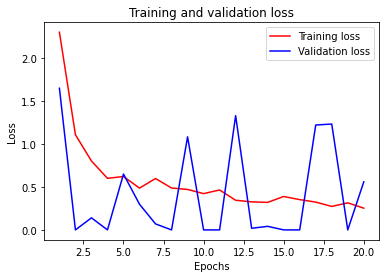

In [27]:
plt.plot(epochs, acc, 'r', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

> You reach a validation accuracy of about 96%. This is much better than what you achieved with the small convnet trained from scratch.

### 5.3.2 Fine-tuning

*Fine-tuning* consists of unfreezing a few of the top layers  of a frozen model base used for feature extraction, and jointly training both the newly added part of the model and these top layers. This is called *fine-tuning* because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

The steps for fine-tuning a network are as follow:
  1. Add your custom network on top of an already-trained base network.
  2. Freeze the base network.
  3. Train the part you added.
  4. Unfreeze some layers in the base network.
  5. Jointly train both these layers and the part you added.

In [28]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

You'll fine-tune the last three convolutional layers, which means all layers up to **block4_pool** should be frozen.

Why not fine-tune more layers? Why not fine-tune the entire convolutional base? You could. But you need to consider the following:
  + Earlier layers encode more-generic, reusable features, whereas layers higher up encode more-specialized features. It's more useful to fine-tune the more specialized features, because these are the ones that need to be repurposed on the new problem.
  + The more parameters you're training, the more you're at risk of overfitting.

#### Freezing all layers up to a specific one

In [0]:
conv_base.trainable = True

In [0]:
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

#### Fine-tuning the model

In [0]:
model.compile(optimizer = optimizers.RMSprop(lr = 1e-5),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

In [32]:
history = model.fit_generator(
     train_generator,
     steps_per_epoch = 100,
     epochs = 50,
     validation_data = validation_generator,
     validation_steps = 50)

Epoch 1/50
100/100 [==============================] - 25s 253ms/step - loss: 0.2483 - acc: 0.9560 - val_loss: 7.3568e-07 - val_acc: 0.9590
Epoch 2/50
100/100 [==============================] - 23s 230ms/step - loss: 0.2855 - acc: 0.9490 - val_loss: 1.7240e-07 - val_acc: 0.9680
Epoch 3/50
100/100 [==============================] - 23s 231ms/step - loss: 0.2012 - acc: 0.9630 - val_loss: 1.8944 - val_acc: 0.9650
Epoch 4/50
100/100 [==============================] - 23s 230ms/step - loss: 0.2019 - acc: 0.9640 - val_loss: 0.4502 - val_acc: 0.9650
Epoch 5/50
100/100 [==============================] - 23s 233ms/step - loss: 0.1880 - acc: 0.9650 - val_loss: 0.2224 - val_acc: 0.9660
Epoch 6/50
100/100 [==============================] - 23s 232ms/step - loss: 0.1544 - acc: 0.9645 - val_loss: 1.2899 - val_acc: 0.9610
Epoch 7/50
100/100 [==============================] - 24s 236ms/step - loss: 0.1773 - acc: 0.9630 - val_loss: 2.3566 - val_acc: 0.9600
Epoch 8/50
100/100 [===========================

In [0]:
model.save('cats_and_dogs_small_4.h5')

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

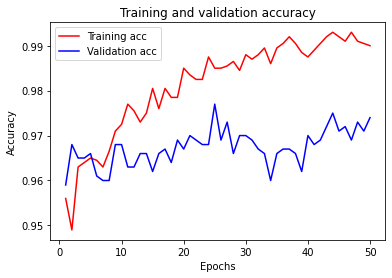

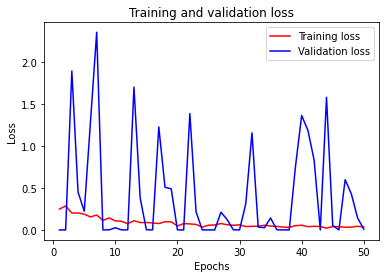

In [35]:
plt.plot(epochs, acc, 'r', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

> After fine tuning the model, the accuracy of the validation data reaches almost 98%. 

But the curves look noisy. To make them more readable, you can smooth them by replacing every loss and accuracy with exponential moving averages of these quantities.

#### Smoothing the plots

In [0]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor+point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

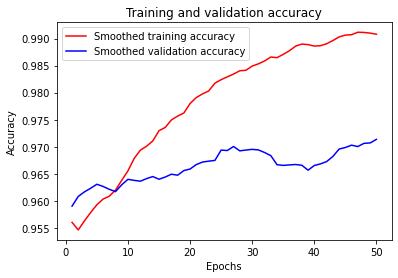

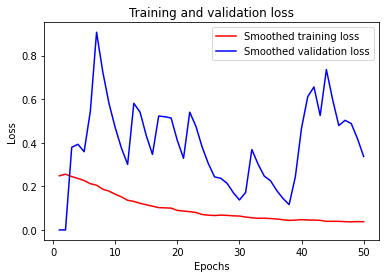

In [37]:
plt.plot(epochs, smooth_curve(acc), 'r', label='Smoothed training accuracy')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and validation accuracy')
plt.show()

plt.figure()
plt.plot(epochs, smooth_curve(loss), 'r', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

> The validation curve now looks much cleaner.

In [38]:
test_generator = test_datagen.flow_from_directory(
         test_dir,
         target_size=(150, 150),
         batch_size=20,
         class_mode='binary')

Found 1000 images belonging to 2 classes.


In [39]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('Test accuarcy:', test_acc)

Test accuarcy: 0.9660000205039978
